In [1]:
import tifffile
import numpy as np
import pandas as pd
import math
import torch 
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cv2
import imageio
import os

# from __future__ import division
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve as filter2
from matplotlib.patches import FancyArrowPatch

import warnings
warnings.filterwarnings('ignore')

Here read the raw data, which has 4600 frames each.

In [2]:
# dir_data = os.path.join(os.path.pardir, 'data', 'demo')
dir_data = '../iAdo2m_jRGECO1a_raw_data/'
file_iAdo2m = os.path.join(dir_data, 'iAdo2m_27202-31801.tif')
file_jRGECO1a = os.path.join(dir_data, 'jRGECO1a_27202-31801.tif')

if os.path.exists(file_iAdo2m) and os.path.exists(file_jRGECO1a):
    iAdo2m = tifffile.imread(file_iAdo2m)
    jRGEC01a = tifffile.imread(file_jRGECO1a)
    print('Files loaded successfully')
else: 
    print('File loading failed')

print(f'Dimension of iAdo2m: {iAdo2m.shape}')
print(f'Dimension of jRGEC01: {jRGEC01a.shape}')


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Files loaded successfully
Dimension of iAdo2m: (4600, 359, 359)
Dimension of jRGEC01: (4600, 359, 359)


In [3]:
iAdo2m_phase = tifffile.imread('../iAdo2m_phase.tiff')
jRGEC01a_phase = tifffile.imread('../jRGEC01a_phase.tiff')
print(iAdo2m_phase.shape, jRGEC01a_phase.shape)

(4600, 359, 359) (4600, 359, 359)


In [4]:
def wave_speed(data, idx, max_dt=5):

    data[data==0] = np.nan

    T, H, W = data.shape 
    x, y = np.meshgrid(np.arange(W), np.arange(H))
    dx, dy = np.meshgrid(np.arange(-10, 11), np.arange(-10,11))
    x_neigh, y_neigh = x.reshape(-1,1)+dx.reshape(1,-1), y.reshape(-1,1)+dy.reshape(1,-1)

    idx_oob = (x_neigh<0) | (x_neigh>=W) | (y_neigh<0) | (y_neigh>=W) # out of boundary pixels
    x_neigh[idx_oob] = 0
    y_neigh[idx_oob] = 0
    idx_neigh = y_neigh * H + x_neigh # neighboring pixels of each pixel
    delta = (2*np.pi / 200)  # if the phase difference is no bigger than delta, then they are equal 
    data[data==0] = np.nan
    data = np.mod(data+np.pi, 2*np.pi) - np.pi

    vx, vy = np.zeros_like(data, dtype=np.float32), np.zeros_like(data, dtype=np.float32) # velocity in x & t direction
    idx_select = idx_neigh[idx.flatten(), :] # indices of neighboring pixels 

    for t in range(max_dt, T-max_dt): 
        frame_t = data[t][idx]  # the phase of selected pixels at frame t 
        dx_sum, dy_sum, n = np.zeros_like(frame_t), np.zeros_like(frame_t), np.zeros_like(frame_t) 
        for dt in range(-max_dt, max_dt+1):
            if dt==0:
                continue 
            frame_tdt = data[t+dt].flatten()[idx_select] # phase of neighboring pixels in frame t+dt 
            flag_equal = (np.abs(frame_tdt-frame_t.reshape(-1,1)) < delta) # find neighboring pixels with the same value in frame (t+dt)
            dx_sum += flag_equal@dx.flatten() / dt
            dy_sum += flag_equal@dy.flatten() / dt
            n += flag_equal.sum(axis=1)
        n[n==0] = np.inf 
        vx[t][idx], vy[t][idx] = dx_sum*1.0/n, dy_sum*1.0/n 
        # if np.mod(t, 10) == 0: 
        #     print(t)
    
    mag = np.sqrt(vx.copy()**2 + vy.copy()**2)

    return vx, vy, mag

def vis_wave(image, idx, wave_x, wave_y, mag=None, thre=None, step=10, linewidth=0.5, head_width=1.5, head_length=2, save=False):
    h, w = image.shape
    if mag is None:
        mag = np.sqrt(wave_x.copy()**2 + wave_y.copy()**2)
    if thre is None:
        thre = np.percentile(mag[idx], 25)

    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(0, h, step): 
        for j in range(0, w, step): 
            if mag[idx, i, j]>thre: 
                ax.arrow(j, i, wave_x[idx,i,j], wave_y[idx,i,j], fc='r', ec='r', linewidth=linewidth, head_width=head_width, head_length=head_length, length_includes_head=False)
    
    if save:
        plt.title(f'flow at t{1050+idx}')
        plt.savefig(f'../flow_{1050+idx}.pdf')

In [5]:
# iAdo2m_ws_vx, iAdo2m_ws_vy, iAdo2m_ws_mag = wave_speed(data=iAdo2m_phase[1050:1450].copy(), idx=~np.isnan(iAdo2m[0]))
# jRGEC01a_ws_vx, jRGEC01a_ws_vy, jRGEC01a_ws_mag = wave_speed(data=jRGEC01a_phase[1050:1450].copy(), idx=~np.isnan(jRGEC01a[0]))

In [5]:
# np.save('../temp_out/ix.npy', iAdo2m_ws_vx)
# np.save('../temp_out/iy.npy', iAdo2m_ws_vy)
# np.save('../temp_out/jx.npy', jRGEC01a_ws_vx)
# np.save('../temp_out/jy.npy', jRGEC01a_ws_vy)
iAdo2m_ws_vx = np.load('../temp_output/ix.npy')
iAdo2m_ws_vy = np.load('../temp_output/iy.npy')
jRGEC01a_ws_vx = np.load('../temp_output/jx.npy')
jRGEC01a_ws_vy = np.load('../temp_output/jy.npy')

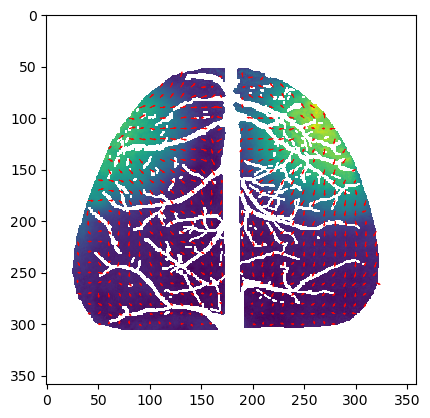

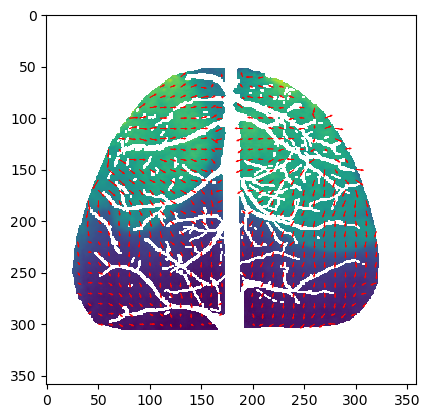

In [6]:
vis_wave(image=iAdo2m[1150], idx=100, wave_x=iAdo2m_ws_vx, wave_y=iAdo2m_ws_vy)
vis_wave(image=jRGEC01a[1150], idx=100, wave_x=jRGEC01a_ws_vx, wave_y=jRGEC01a_ws_vy)

Following comes the process of velocity. We will apply a kernel for convolution and display the color changes.

In [7]:
def conv(ws, method, sigma=None):

    _, h, w = ws.shape
    convo = np.zeros_like(ws)

    if method == 'average':
        kernel = np.ones((3,3)) / 3*3

        for i in range(ws.shape[0]):
            convo[i] = np.convolve(ws[i].flatten(), kernel.flatten(), mode='same').reshape(h,w)
    
    elif method == 'gaussian':
        sigma = 1 if sigma is None else sigma
        
        for i in range(ws.shape[0]):
            convo[i] = gaussian_filter(ws[i], sigma=sigma, mode='constant')
    
    else:
        return ws
    
    return convo

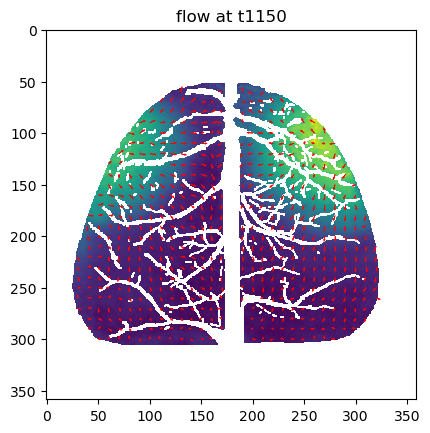

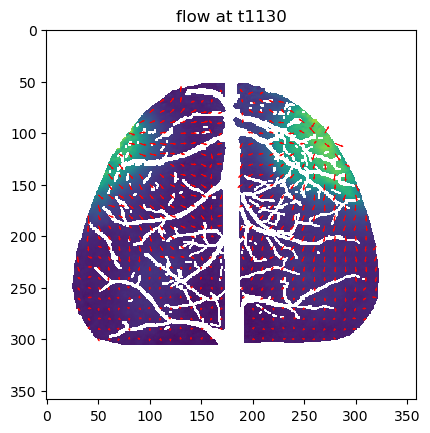

In [8]:
iAdo2m_ws_x = conv(iAdo2m_ws_vx, method=None)
iAdo2m_ws_y = conv(iAdo2m_ws_vy, method=None)
jRGEC01a_ws_x = conv(jRGEC01a_ws_vx, method=None)
jRGEC01a_ws_y = conv(jRGEC01a_ws_vy, method=None)

vis_wave(iAdo2m[1150], idx=100, step=10, wave_x=iAdo2m_ws_x, wave_y=iAdo2m_ws_y, linewidth=0.5, save=True)
vis_wave(jRGEC01a[1130], idx=80, step=10, wave_x=jRGEC01a_ws_x, wave_y=jRGEC01a_ws_y, linewidth=0.5, save=True)

Now produce the video of quiver and color flow throughout whole frames.

In [10]:
from torchvision.utils import flow_to_image

def save_flow(wave_x, wave_y):
    wave_x = torch.from_numpy(wave_x.astype('float32')).unsqueeze(0)
    wave_y = torch.from_numpy(wave_y.astype('float32')).unsqueeze(0)
    wave = torch.cat((wave_x, wave_y), dim=0)

    return ((flow_to_image(wave).permute(1,2,0).cpu().detach().numpy())*255).astype('uint8') #(h,w,3)

In [11]:
iAdo2m_flow, jRGEC01a_flow = [], []

for i in range(iAdo2m_ws_x.shape[0]):
    iAdo2m_flow.append(save_flow(iAdo2m_ws_x[i], iAdo2m_ws_y[i]))

for i in range(jRGEC01a_ws_x.shape[0]):
    jRGEC01a_flow.append(save_flow(jRGEC01a_ws_x[i], jRGEC01a_ws_y[i]))

In [12]:
def generate_video(image_list, output_file, fps=30):

    width, height = image_list[0].shape[1], image_list[0].shape[0]

    video_writer = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), isColor=True)

    for image in image_list:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        video_writer.write(image)

    video_writer.release()
    print('Video is finished.')


generate_video(iAdo2m_flow, output_file='../iAdo2m_flow.mp4', fps=20)
generate_video(jRGEC01a_flow, output_file='../jRGEC01a_flow.mp4', fps=20)

Video is finished.
Video is finished.


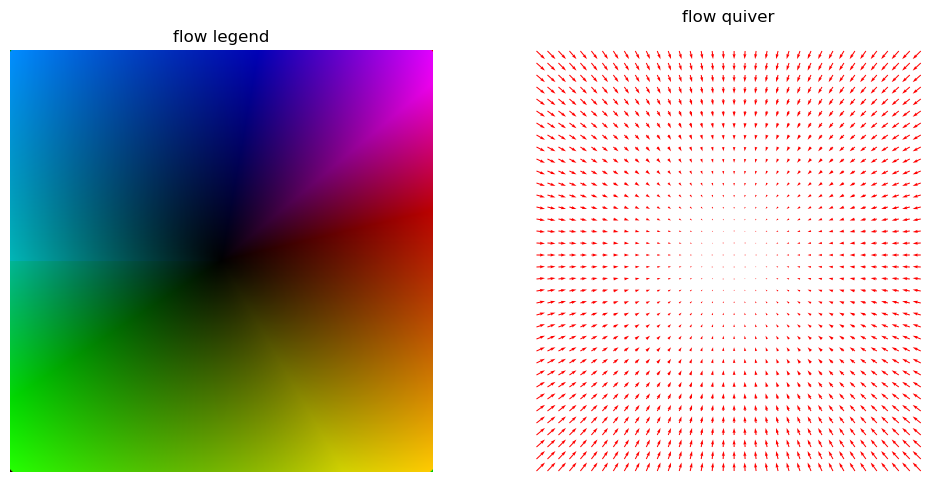

In [13]:
def gen_flow_circle(center, height, width):
    x0, y0 = center
    if x0 >= height or y0 >= width:
        raise AttributeError('ERROR')
    flow = np.zeros((height, width, 2), dtype=np.float32)

    grid_x = np.tile(np.expand_dims(np.arange(width), 0), [height, 1])
    grid_y = np.tile(np.expand_dims(np.arange(height), 1), [1, width])

    grid_x0 = np.tile(np.array([x0]), [height, width])
    grid_y0 = np.tile(np.array([y0]), [height, width])

    flow[:,:,0] = grid_x0 - grid_x
    flow[:,:,1] = grid_y0 - grid_y

    return flow

def quiver_flow(legend, flow):
    """
    flow : np.float32, [h, w, 2], (x, y) format
    """
    h, w, c = flow.shape
    xx, yy = np.meshgrid(range(w), range(h))
    s = 10
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(legend)
    plt.axis('off')
    plt.title('flow legend')
    plt.subplot(122)
    plt.quiver(xx[::s, ::s], yy[::s, ::s], flow[..., 0][::s, ::s], flow[..., 1][::s, ::s], color='red')
    plt.axis('off')
    plt.title('flow quiver')
    plt.savefig('../legend.png')
    plt.show()


flow = gen_flow_circle([179,179], height=359, width=359)
legend = save_flow(flow[:,:,0], flow[:,:,1])
quiver_flow(legend, flow)

In [9]:
h, w = iAdo2m[0].shape
step = 10
points = []
for i in range(0, h, step): 
    for j in range(0, w, step): 
        if ~np.isnan(iAdo2m[0, i,j]):
            points.append((i, j))
print(points)

[(60, 130), (60, 170), (60, 190), (60, 200), (60, 210), (70, 110), (70, 120), (70, 130), (70, 140), (70, 150), (70, 160), (70, 190), (70, 200), (70, 210), (70, 220), (70, 230), (80, 100), (80, 110), (80, 120), (80, 130), (80, 140), (80, 150), (80, 160), (80, 170), (80, 190), (80, 200), (80, 210), (80, 220), (80, 230), (80, 240), (90, 90), (90, 100), (90, 110), (90, 120), (90, 130), (90, 140), (90, 150), (90, 160), (90, 170), (90, 190), (90, 220), (90, 230), (90, 250), (90, 260), (100, 80), (100, 90), (100, 110), (100, 130), (100, 140), (100, 150), (100, 160), (100, 170), (100, 200), (100, 210), (100, 220), (100, 240), (100, 250), (100, 260), (100, 270), (110, 80), (110, 90), (110, 100), (110, 110), (110, 120), (110, 130), (110, 140), (110, 150), (110, 170), (110, 190), (110, 200), (110, 220), (110, 230), (110, 240), (110, 250), (110, 260), (110, 270), (110, 280), (120, 70), (120, 80), (120, 90), (120, 100), (120, 110), (120, 120), (120, 130), (120, 150), (120, 160), (120, 170), (120, 1

In [15]:
def find_min_max(arr):
    arr_without_nan = arr[~np.isnan(arr)]
    min_value = np.nanmin(arr_without_nan)
    max_value = np.nanmax(arr_without_nan)
    return min_value, max_value

min_val, max_val = find_min_max(jRGEC01a)
print("Minimum value (excluding NaN):", min_val)
print("Maximum value (excluding NaN):", max_val)

Minimum value (excluding NaN): -0.6788698
Maximum value (excluding NaN): 3.537099


In [16]:
# original video and quiver
from matplotlib.animation import ArtistAnimation, FFMpegWriter
    
def quiver_video(ori_data, vx, vy, filename, points=points, mag=None, step=10):
    arr_without_nan = ori_data[~np.isnan(ori_data)]
    min_value = np.nanmin(arr_without_nan)
    max_value = np.nanmax(arr_without_nan)

    h, w = vx.shape[1:]
    # if mag is None:
    #     mag = np.sqrt(vx.copy()**2 + vy.copy()**2)

    st = 1050
    et = 1450

    plt.ioff()

    fig, ax = plt.subplots(figsize=(w/50, h/50))
    
    writer = FFMpegWriter(fps=10)
    with writer.saving(fig, filename, dpi=300):
        for t in range(st, et):
            ax.clear()
            ax.imshow(ori_data[t], vmin=min_value, vmax=max_value)
            artists = []
            for p in points:
                i, j = p
                arrow = ax.arrow(j, i, vx[t-st,i,j], vy[t-st,i,j], fc='red', ec='red', linewidth=0.3, head_width=0.8, head_length=1.5, length_includes_head=False)
                artists.append(arrow)
                ax.add_artist(arrow)
                ax.axis('off')
                ax.set_aspect('equal')
            plt.tight_layout()
            writer.grab_frame()
    
    plt.close(fig)
    plt.ion()

quiver_video(iAdo2m, iAdo2m_ws_x, iAdo2m_ws_y, '../iAdo2m_quiver.mp4')
quiver_video(jRGEC01a, jRGEC01a_ws_x, jRGEC01a_ws_y, '../jRGEC01a_quiver.mp4')

In [10]:
def cal_correlation(phase_1, phase_2, points):

    _, h, w = phase_1.shape
    corr_m = np.zeros((h, w))

    for p in points:
        corr_m[p[0], p[1]] = np.corrcoef(phase_1[:, p[0], p[1]], phase_2[:, p[0], p[1]])[0, 1]
    
    return corr_m

In [11]:
pos_num = list(np.asarray(np.nonzero(~np.isnan(iAdo2m[0]))).transpose(1,0))
print(len(pos_num))
corr_phase = cal_correlation(iAdo2m_phase, jRGEC01a_phase, pos_num)

51188


Minimum value (excluding 0 and NaN): 0.09558746588220934
Maximum value (excluding 0 and NaN): 0.9991016988706949
Median value (excluding 0 and NaN): 0.9906834775421836


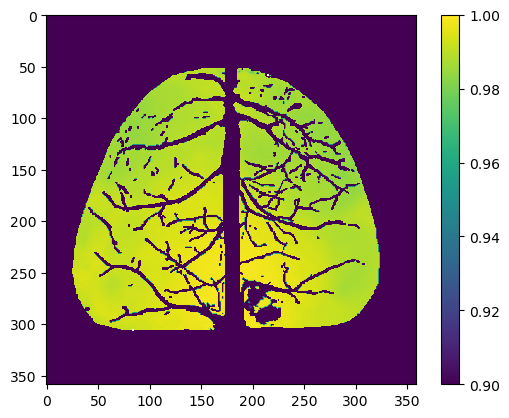

In [55]:
min_val = np.min(corr_phase[(corr_phase != 0) & (~np.isnan(corr_phase))])
max_val = np.max(corr_phase[(corr_phase != 0) & (~np.isnan(corr_phase))])
mid_val = np.median(corr_phase[(corr_phase != 0) & (~np.isnan(corr_phase))])
print("Minimum value (excluding 0 and NaN):", min_val)
print("Maximum value (excluding 0 and NaN):", max_val)
print("Median value (excluding 0 and NaN):", mid_val)
plt.imshow(corr_phase, vmin=0.9, vmax=1)
plt.colorbar()
plt.show()

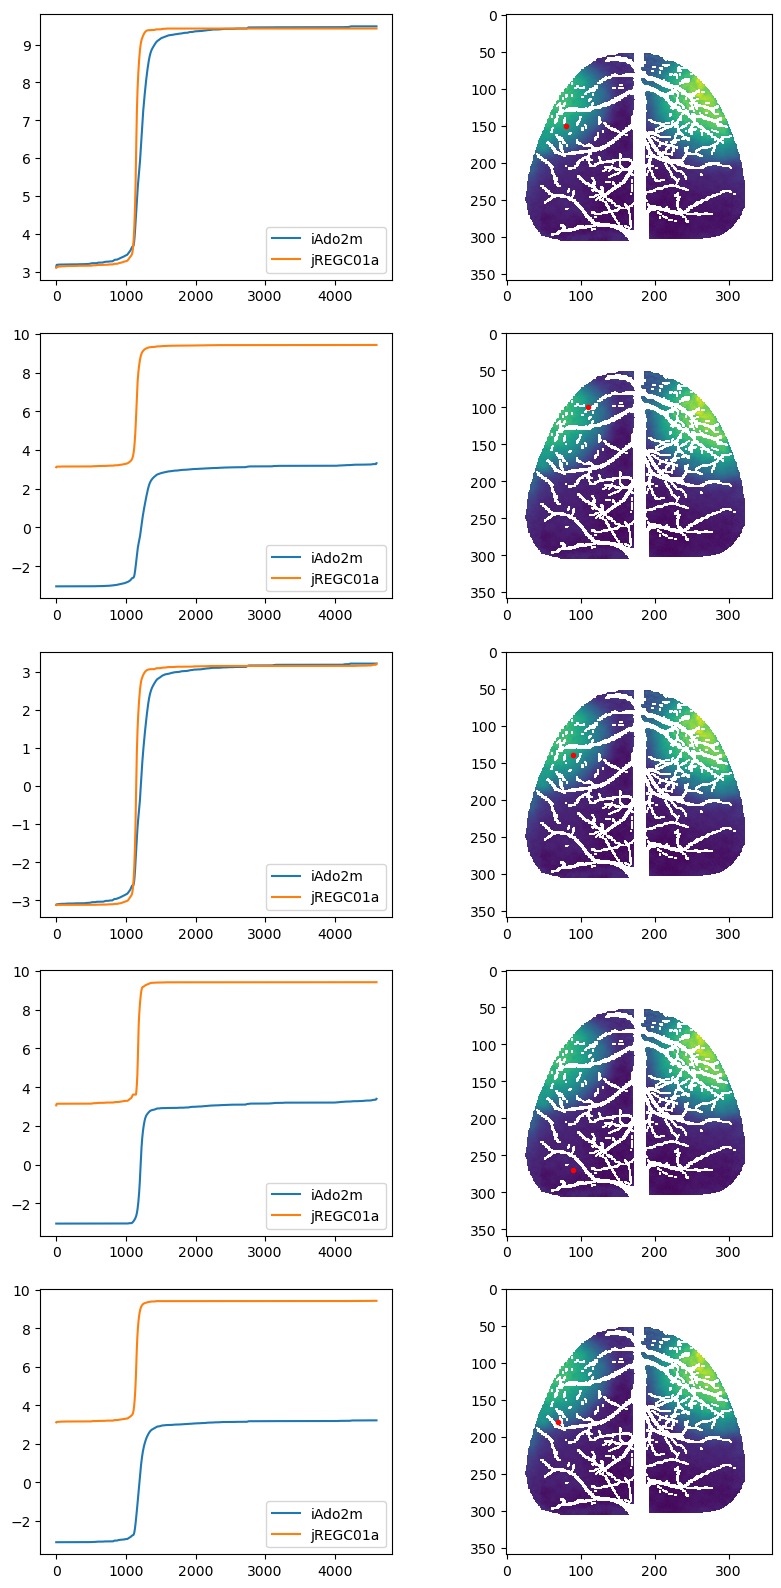

In [13]:
plt.figure(figsize=(10,20))
x = np.array([150, 100, 140, 270, 180])
y = np.array([80, 110, 90, 90, 70])
for i in range(5):
    plt.subplot(5,2,2*i+1)
    # x1 = iAdo2m_ws_x[:, x[i], y[i]]**2
    # y1 = iAdo2m_ws_y[:, x[i], y[i]]**2
    # x2 = jRGEC01a_ws_x[:, x[i], y[i]]**2
    # y2 = jRGEC01a_ws_y[:, x[i], y[i]]**2
    # x1[np.isnan(x1)] = 0
    # y1[np.isnan(y1)] = 0
    # x2[np.isnan(x2)] = 0
    # y2[np.isnan(y2)] = 0
    # mag1 = np.sqrt(x1+y1)
    # mag2 = np.sqrt(x2+y2)

    plt.plot(iAdo2m_phase[:, x[i], y[i]])
    plt.plot(jRGEC01a_phase[:, x[i], y[i]])
    # plt.plot(mag1)
    # plt.plot(mag2)
    plt.legend(['iAdo2m', 'jREGC01a'])
    plt.subplot(5,2,2*i+2)
    plt.imshow(iAdo2m[1150])
    plt.scatter(y[i], x[i], marker=".", color='red')
plt.show()

In [203]:
def find_original(ori_phase, points=pos_num, st=1050, et=1450):

    phase = ori_phase.copy()
    # point_set = np.zeros((et-st, 2))
    point_set = []
    for i in range(st, et):
        max_value = np.max(phase[i])
        max_coords = np.argwhere(phase[i] == max_value)[0]
        if ((phase[:, max_coords[0], max_coords[1]].max() - phase[:, max_coords[0], max_coords[1]].min()) <= (2*np.pi)+0.1) & any(
            np.array_equal(max_coords, p) for p in points): #& ((
            # phase[:, max_coords[0], max_coords[1]].max() * phase[:, max_coords[0], max_coords[1]].min()) < 1):
            point_set.append(max_coords)
        else:
            phase[:, max_coords[0], max_coords[1]] = np.zeros(phase.shape[0])
        # if any(np.array_equal(max_coords, p) for p in points):
            # point_set[i-st] = max_coords
            # print('exist')
        
    
    return point_set

iAdo2m_phase_max_set = find_original(iAdo2m_phase)
jRGEC01a_phase_max_set = find_original(jRGEC01a_phase)

iAdo2m counts: Counter({(156, 304): 25, (157, 304): 23, (183, 46): 19})
jRGEC01a counts: Counter({(299, 193): 97, (52, 196): 57, (106, 259): 23, (115, 69): 17, (115, 68): 16, (168, 67): 12, (306, 162): 12, (177, 56): 7, (129, 73): 3, (168, 65): 3, (265, 195): 3, (266, 196): 3, (266, 197): 3, (166, 62): 2, (167, 64): 2, (166, 64): 1, (168, 66): 1, (265, 196): 1, (292, 153): 1, (295, 157): 1})


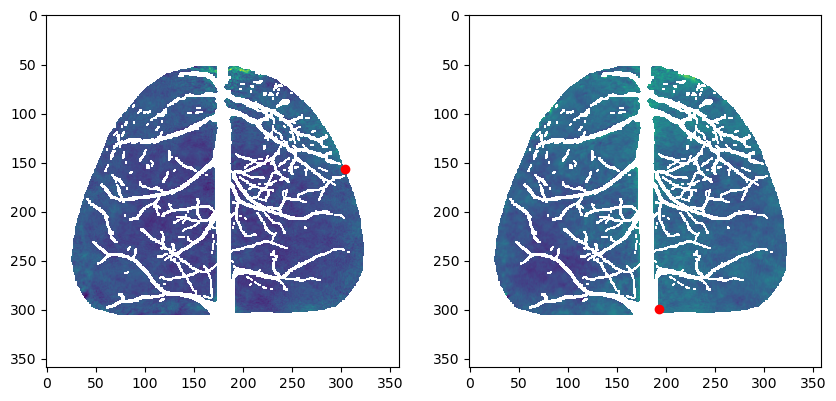

In [204]:
from collections import Counter

def count_elements(lst):
    elements = [tuple(arr) for arr in lst]
    counter = Counter(elements)
    return counter

iAdo2m_count = count_elements(iAdo2m_phase_max_set)
jRGEC01a_count = count_elements(jRGEC01a_phase_max_set)
print("iAdo2m counts:", iAdo2m_count)
print("jRGEC01a counts:", jRGEC01a_count)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(iAdo2m[0])
# for s in iAdo2m_count:
plt.scatter(x=iAdo2m_count.most_common(1)[0][0][1], y=iAdo2m_count.most_common(1)[0][0][0], c='red')
plt.subplot(122)
plt.imshow(jRGEC01a[0])
# for s in jRGEC01a_count:
plt.scatter(x=jRGEC01a_count.most_common(1)[0][0][1], y=jRGEC01a_count.most_common(1)[0][0][0], c='red')
plt.show()

iAdo2m Sources: (array([  4,   4,   4, ..., 395, 395, 395]), array([ 52,  52,  52, ..., 306, 306, 306]), array([150, 151, 152, ..., 158, 159, 161]))
jRGEC01a Sources: (array([  4,   4,   4, ..., 395, 395, 395]), array([ 52,  52,  52, ..., 306, 306, 306]), array([150, 151, 153, ..., 158, 162, 163]))


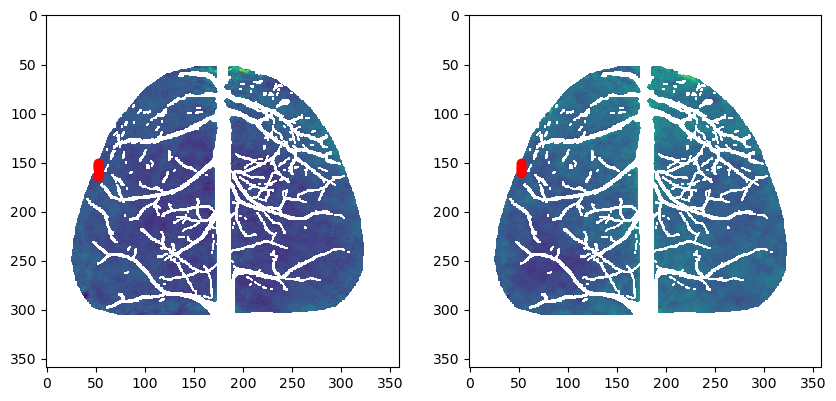

In [22]:
# def calculate_divergence(velocity_field):
#     gradient = np.gradient(velocity_field)
#     divergence = gradient[0][:, :, :, 0] + gradient[1][:, :, :, 1]

#     # combined_divergence = np.sum(divergence, axis=0)
#     sources = np.where(divergence < 0)
#     sinks = np.where(divergence > 0)
#     return divergence, sources, sinks

# iAdo2m_vel_field = np.concatenate([iAdo2m_ws_x[:,:,:,np.newaxis], iAdo2m_ws_y[:,:,:,np.newaxis]], axis=-1)
# iAdo2m_divergence, iAdo2m_sources, iAdo2m_sinks = calculate_divergence(iAdo2m_vel_field)
# jRGEC01a_vel_field = np.concatenate([jRGEC01a_ws_x[:,:,:,np.newaxis], jRGEC01a_ws_y[:,:,:,np.newaxis]], axis=-1)
# jRGEC01a_divergence, jRGEC01a_sources, jRGEC01a_sinks = calculate_divergence(jRGEC01a_vel_field)

# print("iAdo2m Sources:", iAdo2m_sources)
# # print("iAdo2m Sinks:", iAdo2m_sinks)
# print("jRGEC01a Sources:", jRGEC01a_sources)
# # print("jRGEC01a Sinks:", jRGEC01a_sinks)

# plt.figure(figsize=(10,5))
# plt.subplot(121)
# plt.imshow(iAdo2m[0])
# for i in range(10):
#     plt.scatter(iAdo2m_sources[1][i], iAdo2m_sources[2][i], c='red')
# plt.subplot(122)
# plt.imshow(jRGEC01a[0])
# for i in range(10):
#     plt.scatter(jRGEC01a_sources[1][i],jRGEC01a_sources[2][i], c='red')
# plt.show()

iAdo2m Sources: (array([  5,   5,   5, ..., 394, 394, 394]), array([ 51,  51,  51, ..., 307, 307, 307]), array([151, 152, 153, ..., 163, 164, 165]))
iAdo2m Max Sources: Counter({(58, 211): 38, (56, 192): 36, (62, 218): 36, (53, 153): 25, (90, 265): 22, (91, 266): 18, (205, 132): 18, (189, 301): 17, (59, 206): 13, (57, 193): 12, (0, 0): 10, (91, 183): 10, (297, 192): 10, (268, 316): 9, (177, 41): 8, (300, 282): 8, (302, 266): 6, (191, 300): 6, (162, 200): 5, (247, 26): 5, (56, 147): 5, (60, 218): 4, (56, 203): 4, (298, 286): 4, (116, 70): 4, (306, 148): 3, (143, 54): 3, (156, 104): 3, (218, 222): 3, (179, 222): 3, (305, 108): 3, (299, 271): 3, (190, 300): 3, (99, 78): 2, (306, 158): 2, (151, 51): 2, (144, 54): 2, (176, 41): 2, (219, 223): 2, (188, 111): 2, (303, 101): 2, (56, 191): 2, (59, 217): 2, (58, 189): 2, (55, 186): 1, (115, 67): 1, (298, 192): 1, (268, 317): 1, (306, 150): 1, (303, 193): 1, (304, 192): 1, (124, 290): 1, (217, 222): 1, (200, 216): 1, (259, 206): 1, (226, 134): 1,

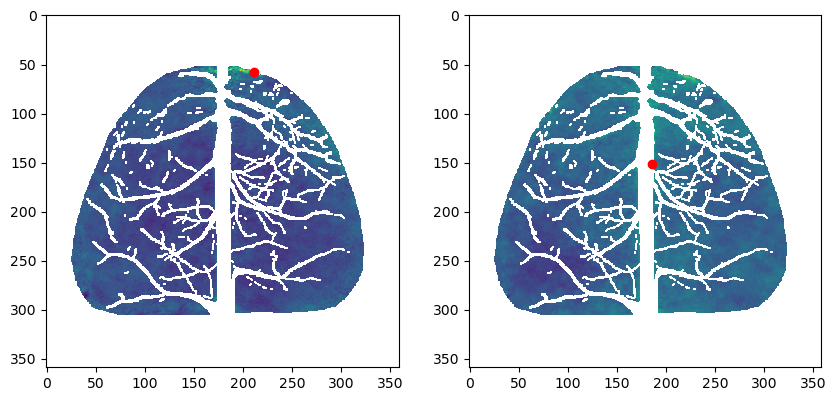

In [194]:
def cal_divergence(vx, vy):
    t = vx.shape[0]
    divergence = np.zeros_like(vx)
    max_sources = []
    min_sinks = []

    for ti in range(t):
        d_vx = np.gradient(vx[ti])
        d_vy = np.gradient(vy[ti])
        divergence[ti] = d_vx[1] + d_vy[0]
        max_sources.append(np.unravel_index(np.argmax(divergence[ti]), divergence[ti].shape))
        min_sinks.append(np.unravel_index(np.argmin(divergence[ti]), divergence[ti].shape))

    sources = np.where(divergence > 0)
    sinks = np.where(divergence < 0)
    return divergence, sources, sinks, count_elements(max_sources), count_elements(min_sinks)

iAdo2m_divergence, iAdo2m_sources, iAdo2m_sinks, iAdo2m_max_sources, iAdo2m_min_sinks = cal_divergence(iAdo2m_ws_x, iAdo2m_ws_y)
jRGEC01a_divergence, jRGEC01a_sources, jRGEC01a_sinks, jRGEC01a_max_sources, jRGEC01a_min_sinks = cal_divergence(jRGEC01a_ws_x, jRGEC01a_ws_y)

print("iAdo2m Sources:", iAdo2m_sources)
print("iAdo2m Max Sources:", iAdo2m_max_sources)
# print("iAdo2m Sinks:", iAdo2m_sinks)
print("jRGEC01a Sources:", jRGEC01a_sources)
print("jRGEC01a Max Sources:", jRGEC01a_max_sources)
# print("jRGEC01a Sinks:", jRGEC01a_sinks)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(iAdo2m[0])
plt.scatter(iAdo2m_max_sources.most_common(1)[0][0][1], iAdo2m_max_sources.most_common(1)[0][0][0], c='red')
plt.subplot(122)
plt.imshow(jRGEC01a[0])
for i in range(1):
    plt.scatter(jRGEC01a_max_sources.most_common(1)[0][0][1], jRGEC01a_max_sources.most_common(1)[0][0][0], c='red')
plt.show()

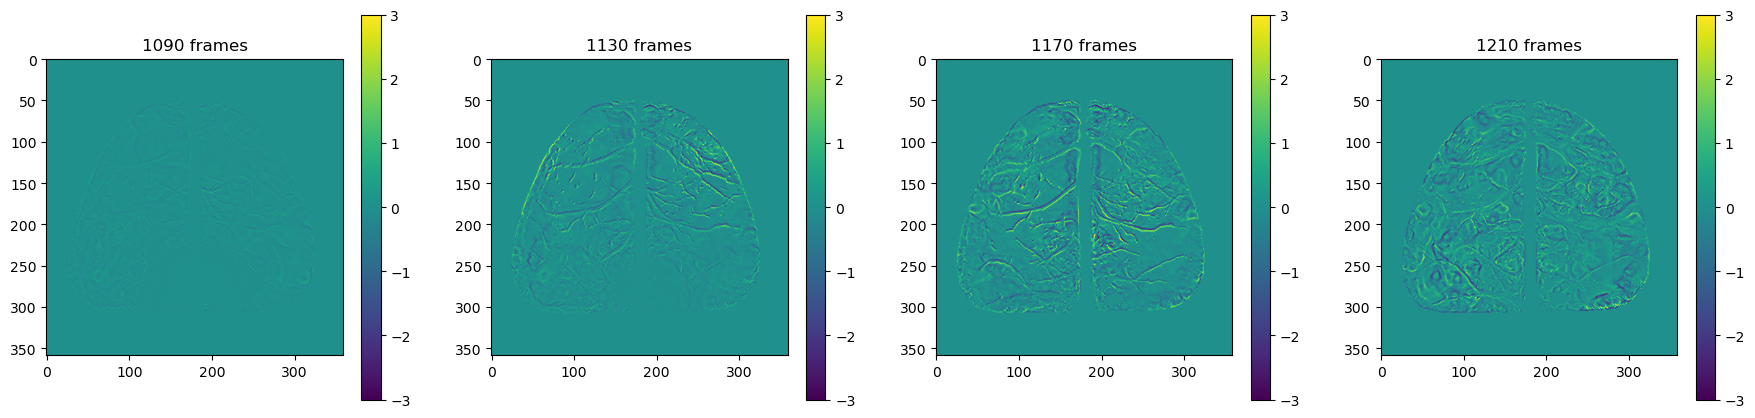

In [202]:
plt.figure(figsize=(22, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(iAdo2m_divergence[40*(i+1)], vmin=-3, vmax=3)
    plt.title(f'{1050+40*(i+1)} frames')
    plt.colorbar()

In [223]:
# try to inpaint
def inpaint_velocity(vx1, vy1, vx2, vy2):
    mask = tifffile.imread('../Mask.tif')
    nan_mask = np.isnan(iAdo2m[0])

    inpaint_mask = np.logical_and(mask, nan_mask).astype('uint8')

    t = vx1.shape[0]
    new_vx1 = np.zeros_like(vx1)
    new_vy1 = np.zeros_like(vy1)
    new_vx2 = np.zeros_like(vx2)
    new_vy2 = np.zeros_like(vy2)

    for ti in range(t):
        new_vx1[ti] = cv2.inpaint(vx1[ti], inpaint_mask, 10, cv2.INPAINT_NS)
        new_vy1[ti] = cv2.inpaint(vy1[ti], inpaint_mask, 10, cv2.INPAINT_NS)
        new_vx2[ti] = cv2.inpaint(vx2[ti], inpaint_mask, 10, cv2.INPAINT_NS)
        new_vy2[ti] = cv2.inpaint(vy2[ti], inpaint_mask, 10, cv2.INPAINT_NS)
    
    return new_vx1, new_vy1, new_vx2, new_vy2

iAdo2m_vx, iAdo2m_vy, jRGEC01a_vx, jRGEC01a_vy = inpaint_velocity(iAdo2m_ws_x, iAdo2m_ws_y, jRGEC01a_ws_x, jRGEC01a_ws_vy)

iAdo2m Sources: (array([  5,   5,   5, ..., 394, 394, 394]), array([ 51,  51,  51, ..., 307, 307, 307]), array([151, 152, 153, ..., 185, 186, 187]))
iAdo2m Max Sources: Counter({(58, 211): 36, (62, 218): 35, (56, 192): 34, (90, 265): 23, (57, 148): 21, (91, 266): 18, (205, 132): 18, (189, 301): 17, (59, 206): 13, (268, 316): 11, (53, 153): 11, (0, 0): 10, (57, 193): 10, (297, 192): 9, (91, 183): 8, (177, 41): 8, (300, 282): 8, (162, 200): 7, (302, 266): 6, (191, 300): 6, (247, 26): 5, (56, 147): 5, (60, 218): 4, (56, 203): 4, (298, 286): 4, (116, 70): 4, (306, 148): 3, (143, 54): 3, (179, 222): 3, (305, 108): 3, (299, 271): 3, (190, 300): 3, (99, 78): 2, (306, 158): 2, (303, 192): 2, (151, 51): 2, (144, 54): 2, (176, 41): 2, (190, 205): 2, (248, 200): 2, (188, 111): 2, (303, 101): 2, (56, 191): 2, (59, 217): 2, (58, 189): 2, (55, 186): 1, (115, 67): 1, (298, 192): 1, (268, 317): 1, (303, 193): 1, (124, 290): 1, (192, 208): 1, (191, 206): 1, (192, 207): 1, (193, 209): 1, (259, 206): 1, 

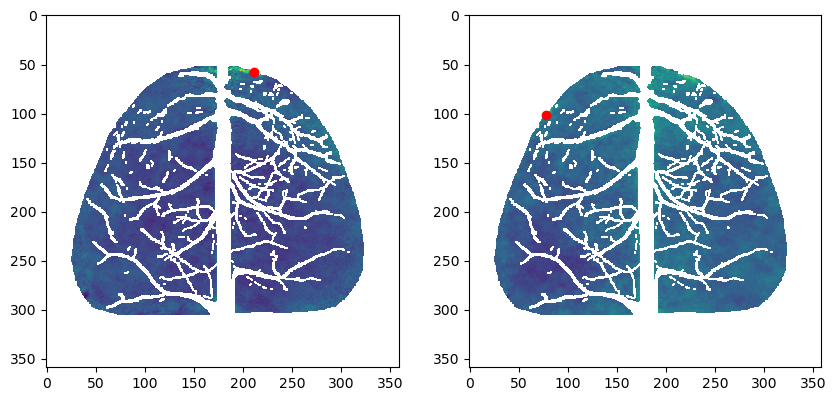

In [225]:
iAdo2m_divergence, iAdo2m_sources, iAdo2m_sinks, iAdo2m_max_sources, iAdo2m_min_sinks = cal_divergence(iAdo2m_vx, iAdo2m_vy)
jRGEC01a_divergence, jRGEC01a_sources, jRGEC01a_sinks, jRGEC01a_max_sources, jRGEC01a_min_sinks = cal_divergence(jRGEC01a_vx, jRGEC01a_vy)

print("iAdo2m Sources:", iAdo2m_sources)
print("iAdo2m Max Sources:", iAdo2m_max_sources)
# print("iAdo2m Sinks:", iAdo2m_sinks)
print("jRGEC01a Sources:", jRGEC01a_sources)
print("jRGEC01a Max Sources:", jRGEC01a_max_sources)
# print("jRGEC01a Sinks:", jRGEC01a_sinks)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(iAdo2m[0])
plt.scatter(iAdo2m_max_sources.most_common(1)[0][0][1], iAdo2m_max_sources.most_common(1)[0][0][0], c='red')
plt.title('iAdo2m origin')
plt.subplot(122)
plt.imshow(jRGEC01a[0])
plt.scatter(jRGEC01a_max_sources.most_common(1)[0][0][1], jRGEC01a_max_sources.most_common(1)[0][0][0], c='red')
plt.tile('jRGEC01a origin')
plt.show()

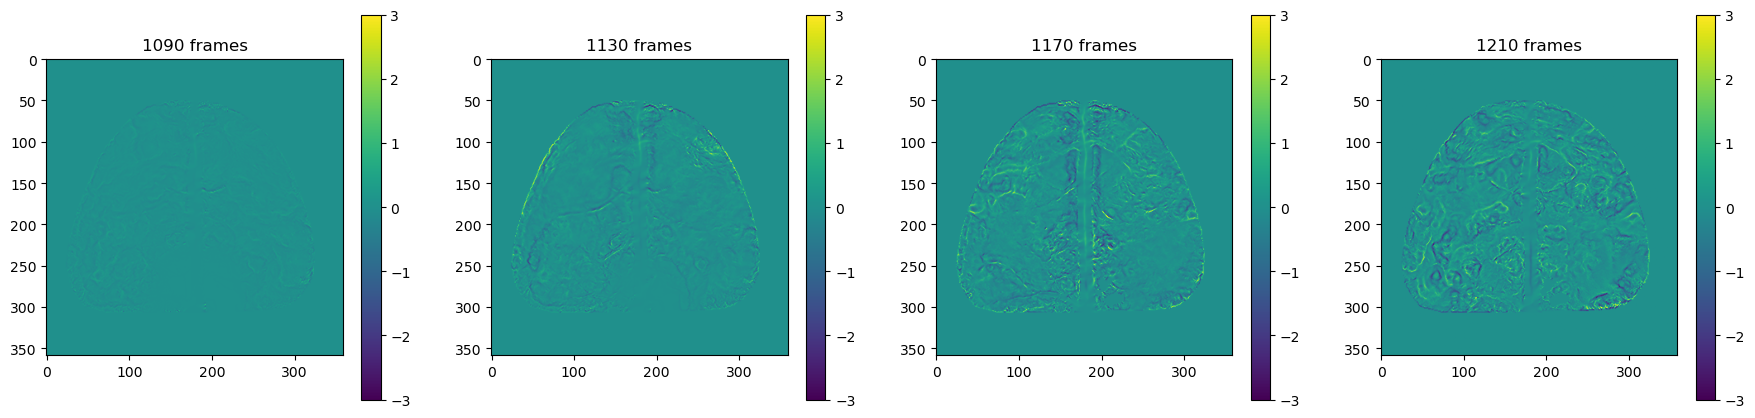

In [227]:
plt.figure(figsize=(22, 5))
plt.title('divergence')
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(iAdo2m_divergence[40*(i+1)], vmin=-3, vmax=3)
    plt.title(f'{1050+40*(i+1)} frames')
    plt.colorbar()